# Linear Regression Analysis and Prediction for IOT

In [25]:
#Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [26]:
#Loading data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv')

In [27]:
#convert datetime to epoch/unix time
#from datetime import datetime

df['unix_diff'] = 1
df['unix']=df.unix_diff.cumsum()
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix_diff,unix
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1,1
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1,2
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1,3
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1,4
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1,5


In [28]:
print(df.head())

   Unnamed: 0        Date      Time  Global_active_power  \
0           0  2006-12-16  17:24:00              4.21600   
1           1  2006-12-16  17:25:00              5.36000   
2           2  2006-12-16  17:26:00              5.37400   
3           3  2006-12-16  17:27:00              5.38800   
4           4  2006-12-16  17:28:00              3.66600   

   Global_reactive_power   Voltage  Global_intensity  Sub_metering_1  \
0                0.41800 234.84000          18.40000         0.00000   
1                0.43600 233.63000          23.00000         0.00000   
2                0.49800 233.29000          23.00000         0.00000   
3                0.50200 233.74000          23.00000         0.00000   
4                0.52800 235.68000          15.80000         0.00000   

   Sub_metering_2  Sub_metering_3             Datetime  gap_monthly  \
0         1.00000        17.00000  2006-12-16 17:24:00          NaN   
1         1.00000        16.00000  2006-12-16 17:25:00          

Q: What is ph? What is mu?

A:"ph" refers to the "autoregressive parameter" of a time series model. The autoregressive parameter, denoted as "p" in the AR(p) model, represents the number of lagged observations that are included as predictor variables in the model.
It establishes how much historical data or prior observations should be taken into account when forecasting the response variable's current value. 

In linear regression, "mu" usually refers to the regularization parameter, which is used to control the amount of regularization applied to the model. Regularization is a technique used to prevent overfitting of a model, which occurs when a model fits too closely to the training data and does not generalize well to new, unseen data.


In [29]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph/1) #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?

A: Assuming the first data point occurs at time step 1 and the (n_s)th time step is 5000, the weight of the first data point on the last prediction is determined as follows:

weight = mu^(5000 - 1) = mu^4999

Substituting mu = 0.9, we get:

weight = 0.9^4999 ≈ 0.000012

Therefore, the first data point will have a relatively minimal weight on the final prediction.



In [31]:
#A new data sample is acquired at every iteration of the for loop.
from sklearn import linear_model
for i in range(2, n_s+1):
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
       #Weights are adjusted to reduce their importance as the time gap between the corresponding data point and the prediction increases.
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #performing linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #storing the model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #using the ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

# Visualizing the data


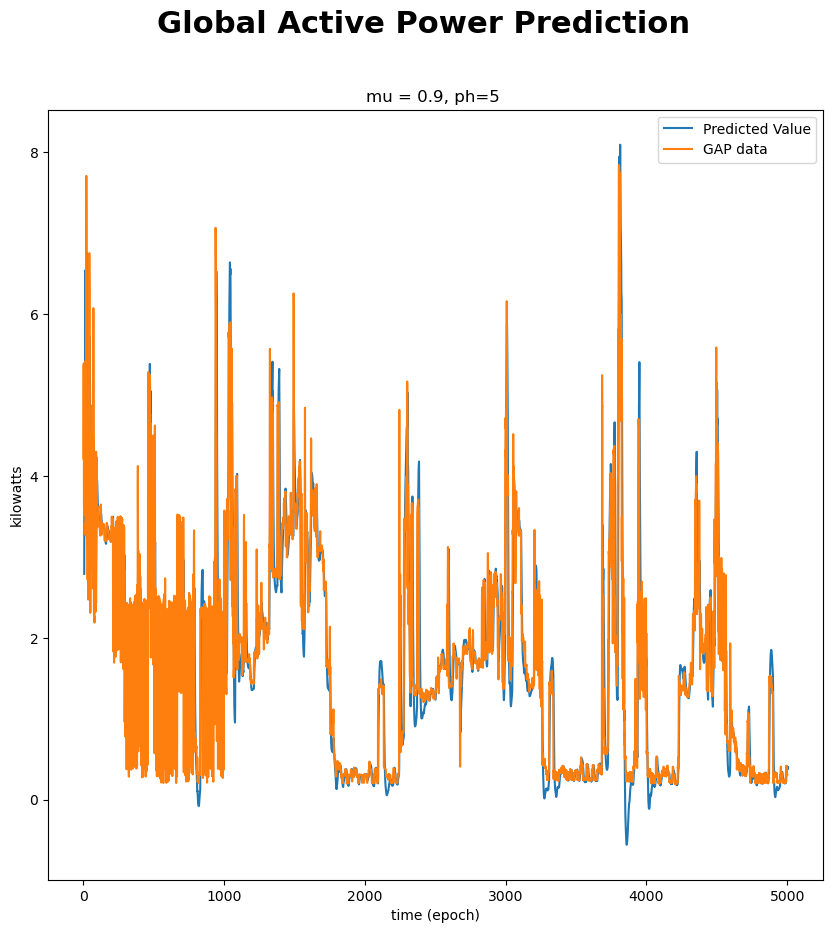

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

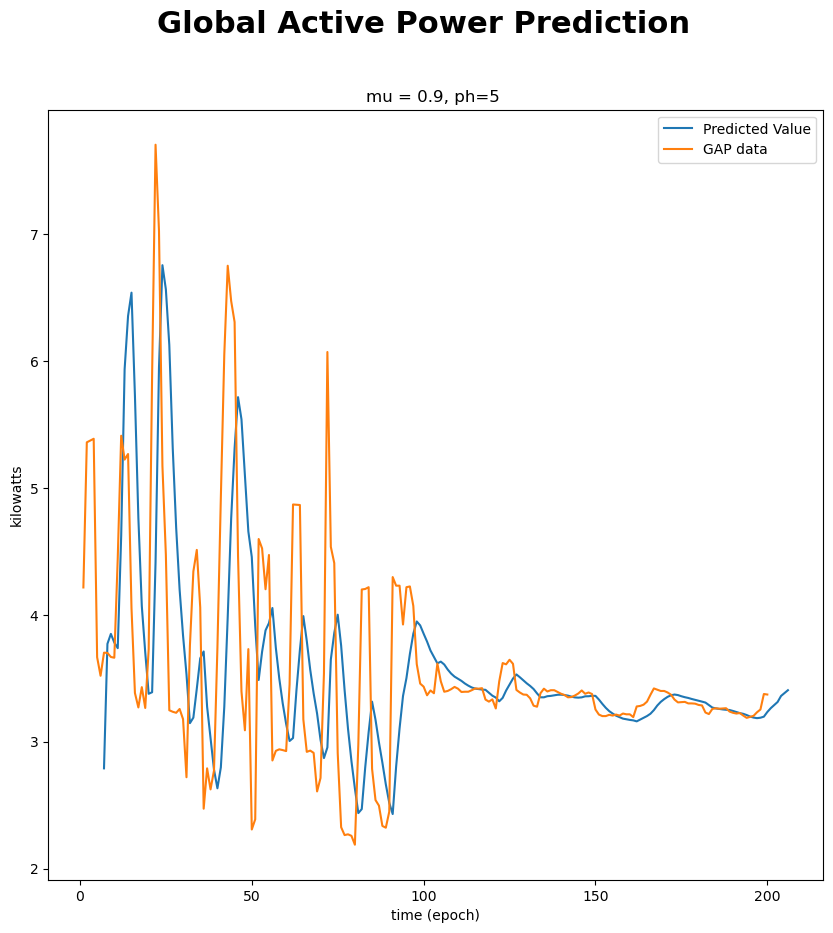

In [35]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

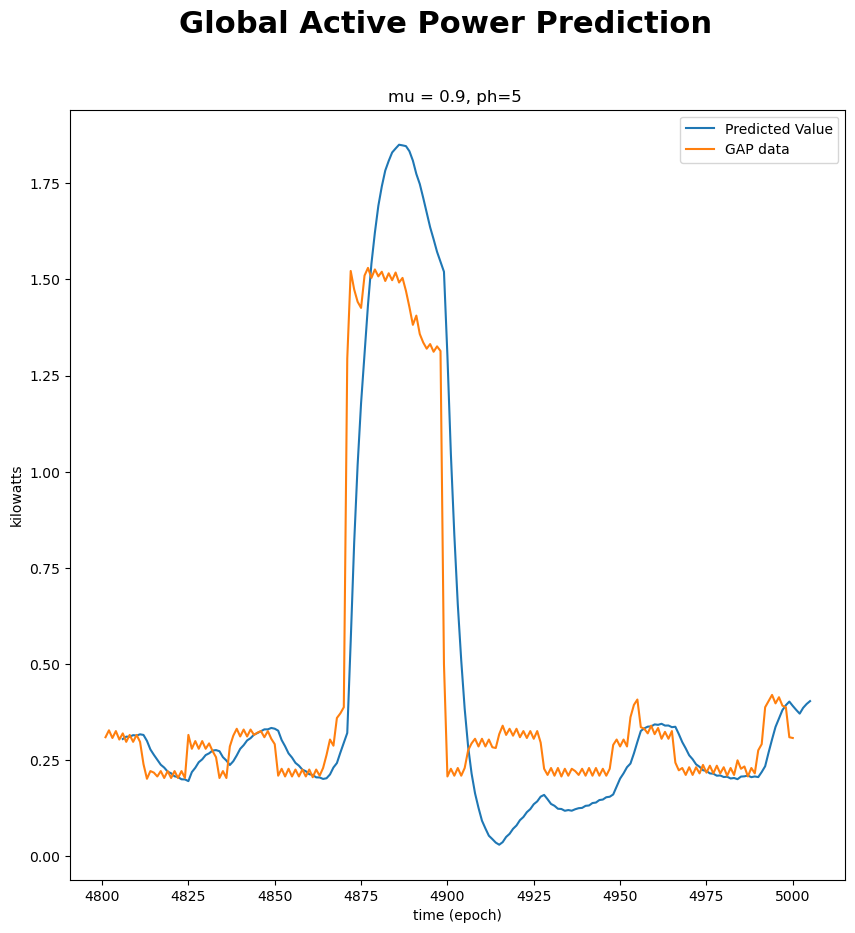

In [36]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [34]:
from sklearn.metrics import mean_squared_error as mse
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

#print("MSE is", mse(ys[ph_index:2000+ph_index-1],yp_pred))

MSE is 0.23828030967147285


Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Based on the visualizations, it is challenging to assess the model's performance. The first and last 200 datapoints/predictions have better representations. The initial 200 predictions demonstrate that the model is tracking the overall trend of the data, but it is unable to capture sudden spikes or drops in Global Active Power. Similarly, the last 200 predictions appear to be performing similarly, with the model failing to capture the abrupt changes in the data.

Furthermore, the high MSE value of 0.238 suggests that the model's predicted values have a relatively large average squared difference from the actual values. This implies that the model needs further refinement because it is not accurately capturing the underlying patterns in the data.


## prediction code with mu = 1 and mu = 0.01

In [38]:
#re-run the prediction model for mu=1
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph/1) #ph/data resolution (how many timesteps is our ph?)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [39]:
# At every iteration of the for loop a new data sample is acquired
from sklearn import linear_model
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

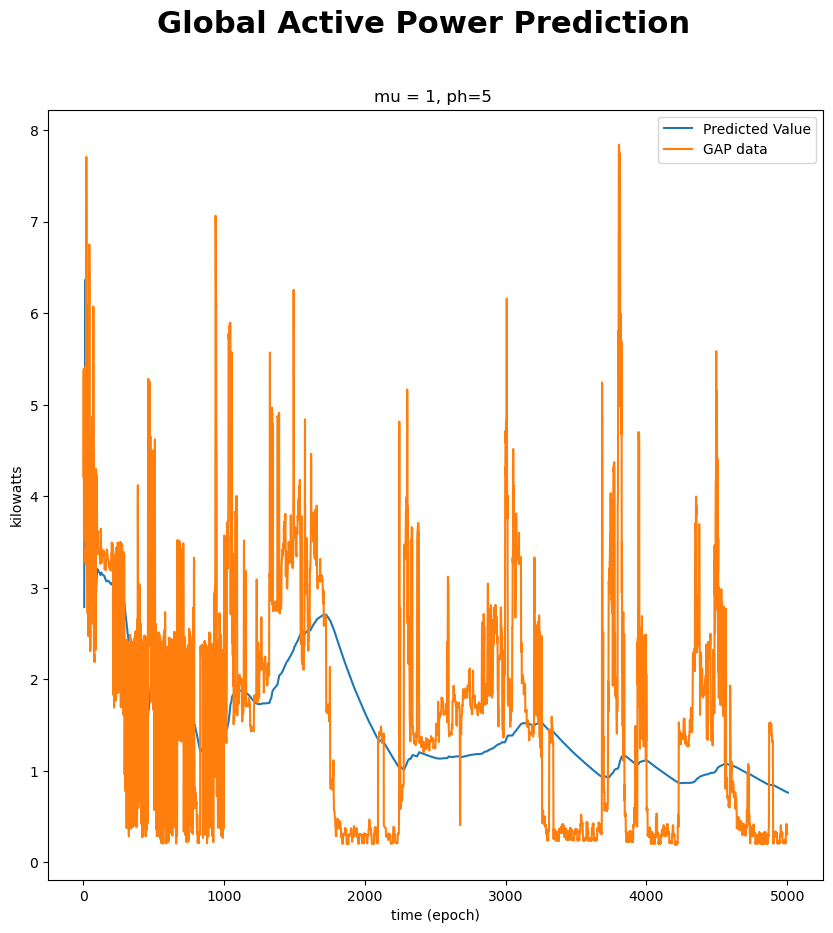

In [40]:
#Visualize the data for mu=1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

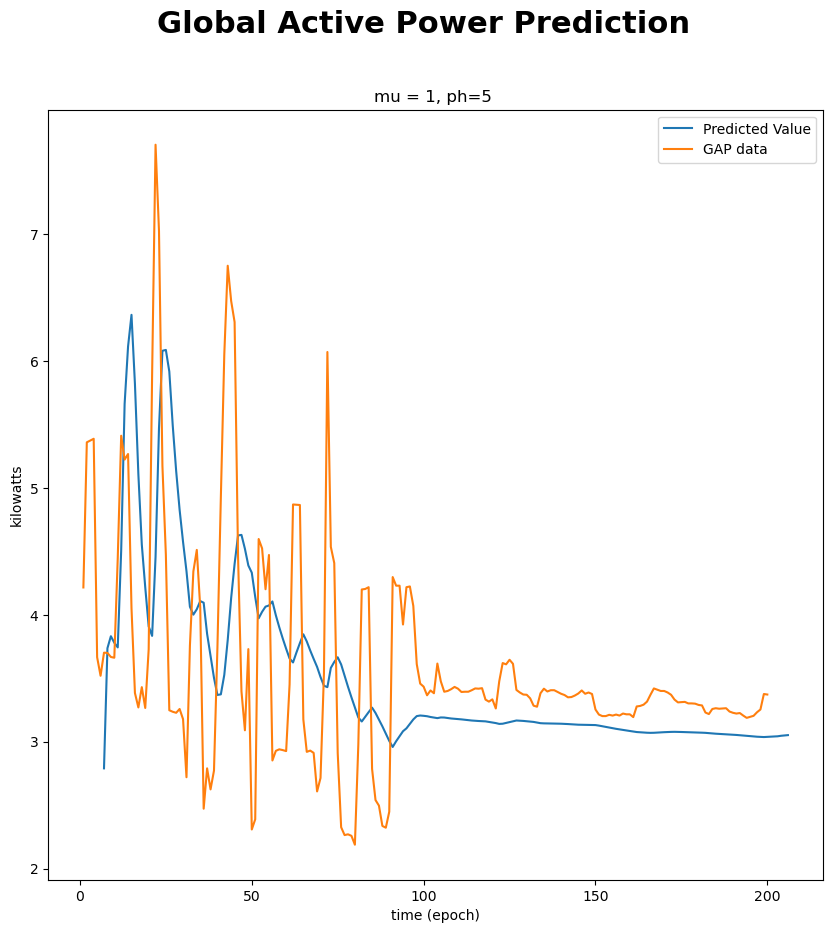

In [41]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph)) #mu=1
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

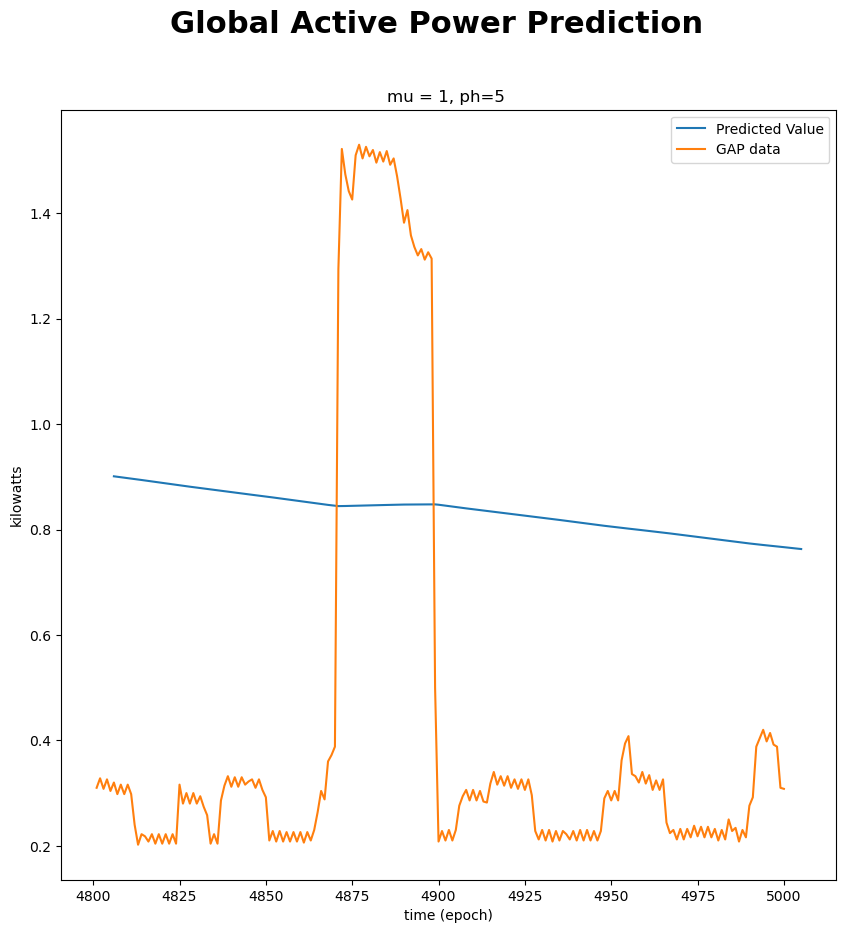

In [42]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph)) #mu=1
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [43]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.384065910739981


In [44]:
#re-run the prediction model for mu=0.01
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph/1) #ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [45]:
# At every iteration of the for loop a new data sample is acquired
from sklearn import linear_model
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

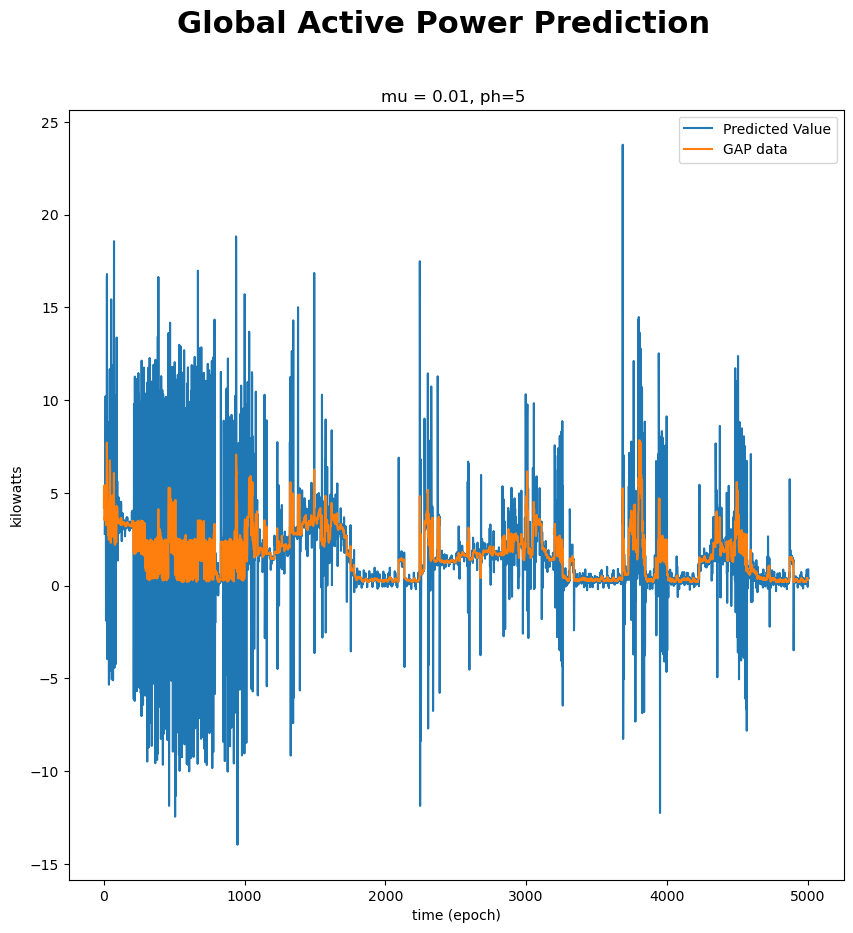

In [46]:
#Visualize the data for mu=0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

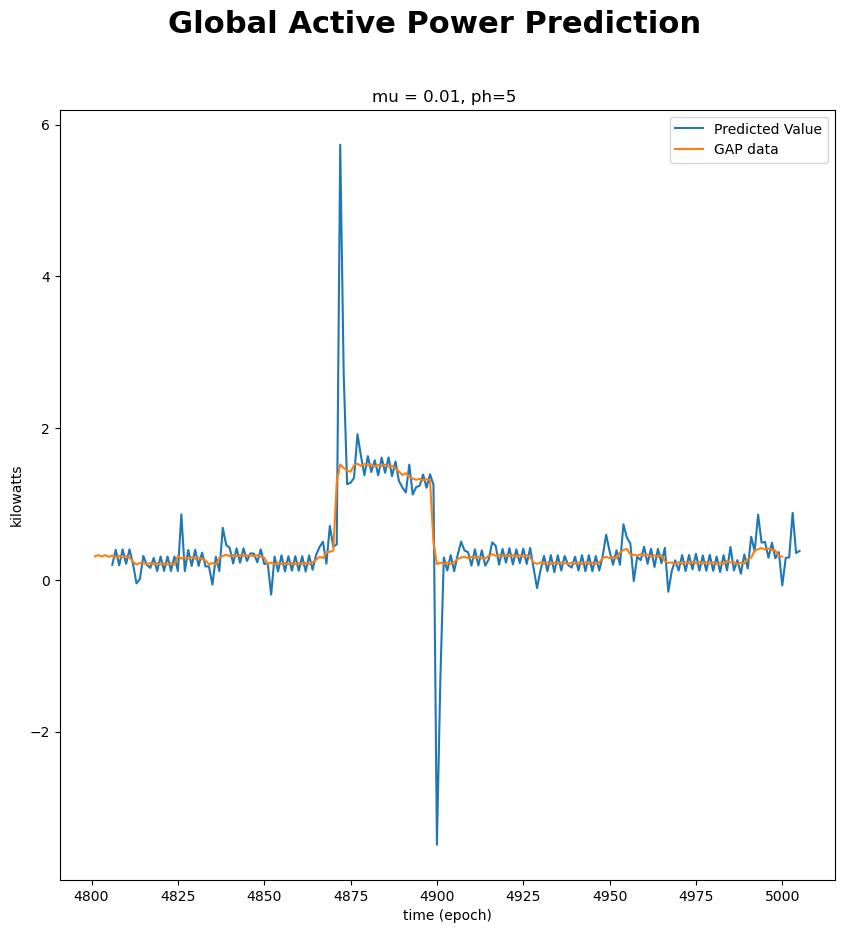

In [49]:
#Plot last 200 data points/predictions for mu = 0.01
#mu=0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [50]:
#Calculate MSE of predictions for mu = 0.01

print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 5.972629574233428


Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?

A:The model with mu=1 appears to perform relatively well in its early predictions, but significant deviation from the actual data is observed in the late predictions. The moderate MSE value of 1.38 suggests that the model has a reasonable level of error, but further refinement may be necessary to improve its accuracy in capturing the patterns of the data.

Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?

A:The performance of the model with mu=0.01 is poor, as evidenced by significant deviations from the actual data in both early and late predictions. In contrast, the visualization of early and late predictions for the mu=1 model is much better. The MSE value for mu=0.01 is very high at 5.97, indicating a significantly higher level of error compared to the mu=1 model.

Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?

A:Out of the three models, the mu=0.9 model appears to be the most effective. The predictions made by this model have low deviation from the actual data, both in the early and late predictions. Additionally, it has the lowest MSE value of 0.23, which is lower than the MSE values of the other two models (mu=1 and mu=0.01). This can be explained by the fact that the mu parameter determines the extent to which past data points are weighted in the prediction model. A mu value of 0.9 strikes a good balance between incorporating enough historical data and avoiding overemphasis on older data points.

Q: What could we do to improve our model and/or make it more realistic and useful?

A:To enhance the performance of the model, we could experiment with other feature selection methods such as utilizing a rolling window of multiple time series variables or integrating external factors such as weather data. Besides, we could consider using decision trees or neural networks as alternative machine learning algorithms for linear regression. Furthermore, to determine whether we can enhance the accuracy of our model, we could test different weighting schemes and adjust hyperparameters settings.

In [53]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Voltage)

ph = 5 #5 minutes
ph_index = int(ph/60)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [54]:
for i in range(2, n_s+1):
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
    
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight= weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
    
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

MSE is 0.6974704841584831


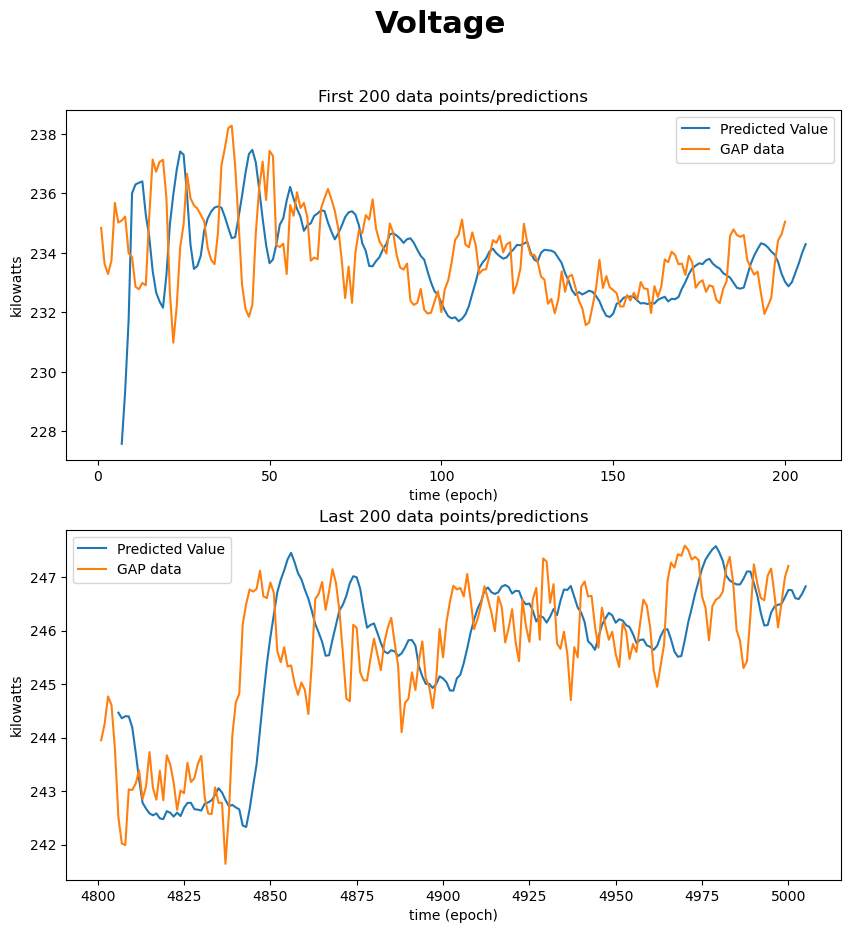

In [55]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.suptitle('Voltage', fontsize=22, fontweight='bold')

# Plot first 200 data points/predictions
axs[0].set_title('First 200 data points/predictions')
axs[0].plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
axs[0].plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
axs[0].set_xlabel('time (epoch)')
axs[0].set_ylabel('kilowatts')
axs[0].legend()

# Plot last 200 data points/predictions
axs[1].set_title('Last 200 data points/predictions')
axs[1].plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
axs[1].plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
axs[1].set_xlabel('time (epoch)')
axs[1].set_ylabel('kilowatts')
axs[1].legend()

# Calculate MSE of predictions
mse_val = mse(ys['Voltage'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse_val)